## DataLoaders requirements

* Use univariate and multivariate time series
* Use labeled (X,y) and unlabeled (X,) datasets
* In-memory and on-disk np.arrays (np.memmap)
* Slice the dataset (based on selected variables and/ or sequence steps)
* Use item and batch tfms
* Create batch with specified output types (TSTensor, TensorCategory, etc)
* Show batch (with tfms)
* Add test data and unlabeled datasets
* Better performance than native Pytorch, fastai v1 & vanilla fastai v2

## Import libraries

In [1]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-x07ykdyd
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-x07ykdyd
  Created wheel for fastai2: filename=fastai2-0.0.17-cp36-none-any.whl size=186716 sha256=5626737b775d6dadda8cc8005e1999d8da76bf8c4297abe58a54522acc92a147
  Stored in directory: /tmp/pip-ephem-wheel-cache-xql8nnzr/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-s2k5jw3z
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-s2k5jw3z
  Created wheel for fastcore: filename=fastcore-0.1.17-cp36-none-any.whl size=28213 sha256=346118a2eceaee9ac391c59f7e3d8e8b2bb717b6601f54ab9e794837fc443ec4
  Stored in directory: /tmp/pip-ephem-wheel-cache-3d12wjt8/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully built fastcore
  Found existing installation: fastcore 0.1.

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [0]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [0]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

## Load data

In [5]:
# dataset id
dsid = 'StarLightCurves'
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)
X_in_memory = np.concatenate((X_train, X_valid))
y_in_memory = np.concatenate((y_train, y_valid)).astype(int)
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X_in_memory)
np.save(f'{folder}/{dsid}/y.npy', y_in_memory)
X_on_disk = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y_on_disk = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r').astype(int)
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X_on_disk)))))

Dataset: StarLightCurves
...data downloaded and decompressed
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



## Performance benchmark

### Pytorch

In [0]:
# Native Pytorch
class PytorchDataset():
    def __init__(self, X, y=None): self.X, self.y = torch.as_tensor(X), torch.as_tensor(y)
    def __getitem__(self, idx): return (self.X[idx], self.y[idx])
    def __len__(self): return len(self.X)

In [7]:
ds    = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dl    = torch.utils.data.DataLoader(ds, batch_size=128)
xb,yb = next(iter(dl))
print(f'shape: {str(len(ds)):10}   bs: {xb.shape}')
%timeit cycle_dl(dl)

shape: 8236         bs: torch.Size([128, 1, 1024])
10 loops, best of 3: 65.5 ms per loop


### Fastai v1

For reference, this are the timings achieved with fastai v1 under the same conditions: 

- cycle_dl:  1.01s
- total training time: 102 s

### Fastai v2

In [8]:
getters = [ItemGetter(0), ItemGetter(1)]
dblock = DataBlock(blocks=(TSTensorBlock, CategoryBlock),
                   getters=getters,
                   splitter=IndexSplitter(splits[1]),
                   item_tfms=None,
                   batch_tfms=None)
source = itemify(X_in_memory, y_in_memory)
dls = dblock.dataloaders(source, bs=64, val_bs=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 3.43 s per loop


Sylvain's recommendation

In [9]:
train_ds = PytorchDataset(np.array(X_train), np.array(y_train).astype(int))
valid_ds = PytorchDataset(np.array(X_valid), np.array(y_valid).astype(int))
dls = DataLoaders.from_dsets(train_ds, valid_ds, batch_size=128, num_workers=0)
xb,yb = next(iter(dls.valid))
print(f'shape: {str(len(dls.valid.dataset)):10}   bs: {xb.shape}')
%timeit cycle_dl(dls.valid)

shape: 8236         bs: torch.Size([128, 1, 1024])
1 loop, best of 3: 892 ms per loop


## NumpyDatasets & NumpyDataLoader

In [0]:
# class Datasets(FilteredBase):
#     "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
#     def __init__(self, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
#         super().__init__(dl_type=dl_type)
#         self.tls = L(tls if tls else [TfmdLists(items, t, **kwargs) for t in L(ifnone(tfms,[None]))])
#         self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

#     def __getitem__(self, it):
#         res = tuple([tl[it] for tl in self.tls])
#         return res if is_indexer(it) else list(zip(*res))

#     def __getattr__(self,k): return gather_attrs(self, k, 'tls')
#     def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
#     def __len__(self): return len(self.tls[0])
#     def __iter__(self): return (self[i] for i in range(len(self)))
#     def __repr__(self): return coll_repr(self)
#     def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
#     def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
#     def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
#     def overlapping_splits(self): return self.tls[0].overlapping_splits()
#     def new_empty(self): return type(self)(tls=[tl.new_empty() for tl in self.tls], n_inp=self.n_inp)
#     @property
#     def splits(self): return self.tls[0].splits
#     @property
#     def split_idx(self): return self.tls[0].tfms.split_idx
#     @property
#     def items(self): return self.tls[0].items
#     @items.setter
#     def items(self, v):
#         for tl in self.tls: tl.items = v

#     def show(self, o, ctx=None, **kwargs):
#         for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
#         return ctx

#     @contextmanager
#     def set_split_idx(self, i):
#         old_split_idx = self.split_idx
#         for tl in self.tls: tl.tfms.split_idx = i
#         yield self
#         for tl in self.tls: tl.tfms.split_idx = old_split_idx


In [0]:
def is_none(o):
    return o in [[], [None], None]
    
def ifnotnone(a, b):
    "`a` if `a` is None else `b`"
    return a if a is not None else b

def ifnoneelse(a, b, c):
    "`b` if `a` is None else `c`"
    return b if a is None else c

In [0]:
class NumpyDatasets(Datasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = None, None # Expected X and y output types (torch.Tensor - default - or subclass)
    def __init__(self, X=None, y=None, items=None, sel_vars=None, sel_steps=None, tfms=None, tls=None, n_inp=None, dl_type=None, 
                 preprocess=False, **kwargs):

        if tls is None: items = ifnoneelse(y,tuple((X,)),tuple((X, y)))
        self.tfms = L(ifnone(tfms,[None]*len(ifnone(tls,items))))
        self.sel_vars = slice(None) if sel_vars is None else sel_vars
        self.sel_steps = slice(None) if sel_steps is None else sel_steps
        self.tls = L(tls if tls else [TfmdLists(item, t, **kwargs) for item,t in zip(items,self.tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        self.ptls = L([tl.items if is_none(tfm) else np.stack(tl[:]) if preprocess else tl for tl,tfm in zip(self.tls, self.tfms)])
        self._get_types()
        self.preprocess = preprocess
            
    def _get_types(self):
        if self.tls: 
            self.types = [type(tl[0]) if isinstance(tl[0], torch.Tensor) else torch.as_tensor for tl in self.tls]
            if self._xtype is not None: self.types[0] = self._xtype
            if len(self.types) == 2 and self._ytype is not None: self.types[1] = self._ytype
    
    def __getitem__(self, it):
        return tuple([typ(ptl[it][self.sel_vars, self.sel_steps] if i==0 else ptl[it]) for i,(ptl,typ) in enumerate(zip(self.ptls,self.types))])
    
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp, 
                                           preprocess=self.preprocess, tfms=self.tfms, sel_vars=self.sel_vars, sel_steps=self.sel_steps)
    
    def _new(self, X, *args, y=None, **kwargs): 
        items = ifnone(items,ifnoneelse(y,tuple((X,)),tuple((X, y))))
        return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    
    @property
    def vars(self): return self[0][0].shape[-2]

class TSDatasets(NumpyDatasets):
    "A dataset that creates tuples from X (and y) and applies `item_tfms`"
    _xtype, _ytype = TSTensor, None # Expected X and y output types (torch.Tensor - default - or subclass)
    
class NumpyDataLoader(TfmdDL):
    do_item = noops
    
    def create_batch(self, b): return self.dataset[b]
    
    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        b = self.one_batch()
        b = itemify(b)
        if nrows is None: 
            sqrt = math.sqrt(len(b))
            rows = min(math.ceil(sqrt), len(b)) 
        if ncols is None: ncols = len(b) // nrows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(b[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(self.dataset.decode(tup), ax=ax)
            plt.tight_layout()

@delegates(plt.subplots)
def show_tuple(tup, ax=None, **kwargs):
    "Display a timeseries plot from a tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], ax=ax, **kwargs)
    
class TSDataLoader(NumpyDataLoader): pass



#     def test_dl(self:DataLoaders, test_items, rm_type_tfms=None, with_labels=False, **kwargs):
#         "Create a test dataloader from `test_items` using validation transforms of `dls`"
#         test = test_set(self.valid, test_items, rm_tfms=rm_type_tfms, with_labels=with_labels
#                         ) if isinstance(self.valid, (Datasets, NumpyDatasets, TfmdLists)) else test_items
#         return self.valid.new(test, **kwargs)

In [0]:
bs = 128
idx = np.random.randint(len(X_in_memory), size=bs)
train_idx = np.random.randint(len(splits[0]), size=bs)
valid_idx = np.random.randint(len(splits[1]), size=bs)

In [16]:
tfms = [None, [Categorize()]]
# tfms = None
# dsets = NumpyDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=False)
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
valid_ds[0]

(TSTensor(vars:1, len:1024), TensorCategory(1))

In [17]:
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls = TSDataLoaders(train_dl, valid_dl)
b = next(iter(dls.valid))
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2,
         1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2,
         2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2,
         1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
         2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2,
         2, 2, 2, 2, 1, 2, 2, 0]))

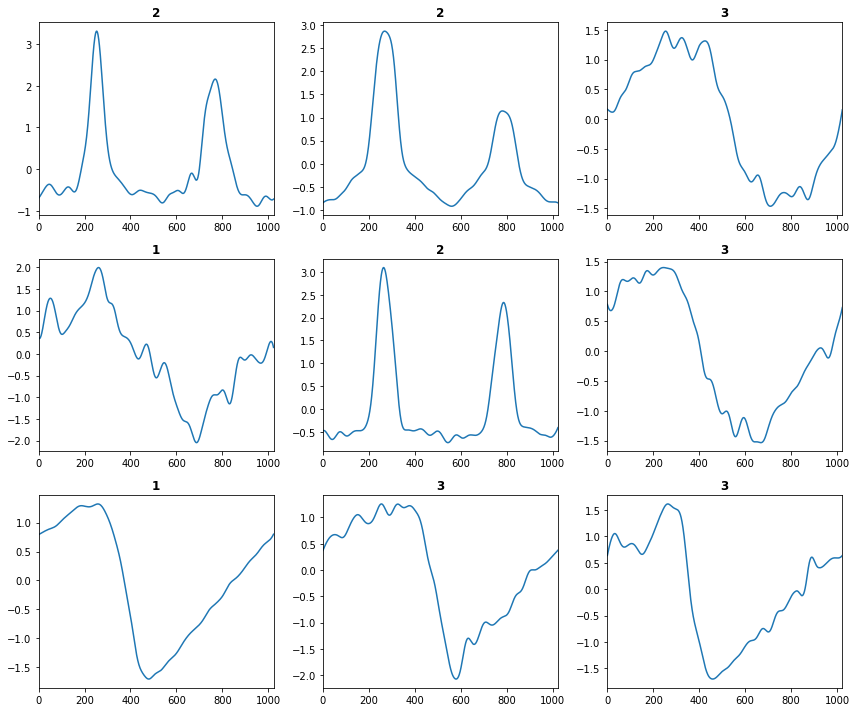

In [22]:
dls.train.show_batch()

In [23]:
X_val = X_in_memory[splits[1]]
y_val = y_in_memory[splits[1]]
%timeit tuple((TSTensor(X_val[valid_idx]), TensorCategory(y_val[valid_idx])))

The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 198 µs per loop


In [26]:
%timeit valid_ds[valid_idx]

100 loops, best of 3: 14.5 ms per loop


In [27]:
%timeit cycle_dl(valid_dl)

1 loop, best of 3: 929 ms per loop


In [20]:
%timeit valid_ds[valid_idx]

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 186 µs per loop


In [31]:
%timeit cycle_dl(valid_dl)

10 loops, best of 3: 37 ms per loop


In [10]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X_in_memory, y_in_memory, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True, num_workers=0)
valid_dl = TSDataLoader(valid_ds, bs=128, num_workers=0)
dls   = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.704361,1.004038,0.777319,00:03
1,0.571141,0.677692,0.835236,00:02
2,0.484006,0.415430,0.855877,00:02
3,0.410333,0.458810,0.825401,00:02
4,0.343993,0.243812,0.940505,00:02
5,0.287211,1.100354,0.855148,00:02
6,0.243030,0.213324,0.916829,00:02
7,0.211733,0.282990,0.863162,00:02
8,0.184711,0.294763,0.870811,00:02
9,0.158757,0.145911,0.960175,00:02


74.82915663719177


In [9]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X_on_disk, y_on_disk, tfms=tfms, splits=splits, preprocess=True)
train_ds = dsets.train
valid_ds = dsets.valid
train_dl = TSDataLoader(train_ds, bs=64, shuffle=True, drop_last=True)
valid_dl = TSDataLoader(valid_ds, bs=128)
dls = TSDataLoaders(train_dl, valid_dl, device=default_device())
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(25, lr_max=1e-3)
print(time.time() - start)

epoch,train_loss,valid_loss,accuracy,time
0,0.799278,1.068762,0.577222,00:03
1,0.647836,0.694410,0.835600,00:03
2,0.546813,0.423343,0.851627,00:03
3,0.451487,0.337685,0.856484,00:03
4,0.392121,0.434699,0.834628,00:03
5,0.338288,0.906969,0.849077,00:03
6,0.302274,0.739665,0.855027,00:03
7,0.265216,0.229490,0.928485,00:03
8,0.227199,0.891239,0.787882,00:03
9,0.200662,0.167834,0.956897,00:03


82.7504723072052
